In [1]:
#importing packages
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import scipy.optimize as spop
import matplotlib.pyplot as plt

In [2]:
#specifying parameters
stocks = ['RIO','BHP']
start = '2022-04-25'
end = '2023-06-13'
fee = 0.001
window = 252
t_threshold = -2.5
#retrieving data
data = pd.DataFrame()
returns = pd.DataFrame()
for stock in stocks:
    prices = yf.download(stock, start, end)
    data[stock] = prices['Close']
    returns[stock] = np.append(data[stock][1:].reset_index(drop=True)/data[stock][:-1].reset_index(drop=True) - 1 , 0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


day 2023-04-26 00:00:00

long position on RIO and short position on BHP
gross daily return: 0.01%
net daily return: -0.09%
cumulative net return so far: -0.09%

day 2023-04-27 00:00:00

long position on RIO and short position on BHP
gross daily return: 0.49%
net daily return: 0.49%
cumulative net return so far: 0.4%

day 2023-04-28 00:00:00

long position on RIO and short position on BHP
gross daily return: -0.62%
net daily return: -0.62%
cumulative net return so far: -0.23%

day 2023-05-01 00:00:00

long position on RIO and short position on BHP
gross daily return: -0.11%
net daily return: -0.11%
cumulative net return so far: -0.34%

day 2023-05-02 00:00:00

long position on RIO and short position on BHP
gross daily return: -0.97%
net daily return: -0.97%
cumulative net return so far: -1.31%

day 2023-05-03 00:00:00

long position on RIO and short position on BHP
gross daily return: -0.82%
net daily return: -0.82%
cumulative net return so far: -2.12%

day 2023-05-04 00:00:00

long pos

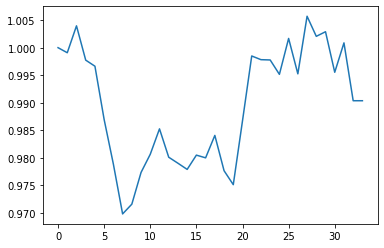

In [3]:
#initialising arrays
gross_returns = np.array([])
net_returns = np.array([])
t_s = np.array([])
stock1 = stocks[0]
stock2 = stocks[1]
#moving through the sample
for t in range(window, len(data)):
    #defining the unit root function: stock2 = a + b*stock1
    def unit_root(b):
        a = np.average(data[stock2][t-window:t] - b*data[stock1][t-window:t])
        fair_value = a + b*data[stock1][t-window:t]
        diff = np.array(fair_value - data[stock2][t-window:t])
        diff_diff = diff[1:] - diff[:-1]
        reg = sm.OLS(diff_diff, diff[:-1])
        res = reg.fit()
        return res.params[0]/res.bse[0]
    #optimising the cointegration equation parameters
    res1 = spop.minimize(unit_root, data[stock2][t]/data[stock1][t], method='Nelder-Mead')
    t_opt = res1.fun
    b_opt = float(res1.x)
    a_opt = np.average(data[stock2][t-window:t] - b_opt*data[stock1][t-window:t])
    #simulating trading
    fair_value = a_opt + b_opt*data[stock1][t]
    if t == window:
        old_signal = 0
    if t_opt > t_threshold:
        signal = 0
        gross_return = 0
    else:
        signal = np.sign(fair_value - data[stock2][t])
        gross_return = signal*returns[stock2][t] - signal*returns[stock1][t]
    fees = fee*abs(signal - old_signal)
    net_return = gross_return - fees
    gross_returns = np.append(gross_returns, gross_return)
    net_returns = np.append(net_returns, net_return)
    t_s = np.append(t_s, t_opt)
    # interface: reporting daily positions and realised returns
    print('day '+str(data.index[t]))
    print('')
    if signal == 0:
        print('no trading')
    elif  signal == 1:
        print('long position on '+stock2+' and short position on '+stock1)
    else:
        print('long position on '+stock1+' and short position on '+stock2)
    print('gross daily return: '+str(round(gross_return*100,2))+'%')
    print('net daily return: '+str(round(net_return*100,2))+'%')
    print('cumulative net return so far: '+str(round(np.prod(1+net_returns)*100-100,2))+'%')
    print('')
    old_signal = signal
#plotting equity curves
# plt.plot(np.append(1,np.cumprod(1+gross_returns)))
plt.plot(np.append(1,np.cumprod(1+net_returns)))
